In [1]:
import numpy as np # data handling
import os # path handling
import matplotlib.pyplot as plt # visualization
import nrrd # mri nrrd file reading
import nibabel as nib # mri nii file reading 
import pandas as pd # for general table handling
import openpyxl # for reading for excel tables
import pyvista as pv # for reading vtk
import seaborn as sns # for beautiful plots
import json # to save header files
import vtk # to handel mri files
import time
import h5py
from nibabel.processing import resample_to_output, conform
from preprocessing_utils import *
import nilearn
from nilearn.plotting import plot_roi, plot_anat



import sys
sys.path.insert(0, 'utils')
from preprocessing_utils import read_data_names, animate_img

In [2]:
# Write all important paths for read/save here
# if you don't know them, just ommit them (might evoke some errors)
path_to_original = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_new"
path_to_data = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery"
path_to_processed_data = "../data/USZ_BrainArtery_processed/"
path_to_processed_bias_data = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data" 
path_to_headers = "/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_analysis/data_ext_headers"
path_to_data_analysis = "/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_analysis/ADAM"
path_to_raw_data = "../data/USZ_BrainArtery_raw/"
path_to_data_splits = "/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_splits"
path_to_external_data = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_npy/data/'
path_to_new_data = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/'
path_to_new_processed_data = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/ADAM/data"

## Data Read-in

In [6]:
# Iterate through all folders, and save names of files
def get_mri_list(path_to_data):
    MRI_file_list = []

    for mri_file_name in os.listdir(path_to_data):
        mri_file_path = os.path.join(path_to_data, mri_file_name)
        if os.path.isdir(mri_file_path) and not mri_file_name.startswith('.'):
            
            MRI_file = {'name': mri_file_name,
                'path': mri_file_path,
                'nii': [],
            'nrrd': [],
            'vtk': [],
            'ctbl': []}

            for mri_file_content_name in os.listdir(mri_file_path):
                mri_file_content_path = os.path.join(mri_file_path, mri_file_content_name)
                if mri_file_content_name.endswith(".nii") or mri_file_content_name.endswith(".nii.gz"):
                    MRI_file['nii'].append(mri_file_content_path)
                elif mri_file_content_name.endswith(".nrrd"):
                    MRI_file['nrrd'].append(mri_file_content_path)
                elif mri_file_content_name.endswith(".vtk"):
                    MRI_file['vtk'].append(mri_file_content_path)
                elif mri_file_content_name.endswith(".ctbl"):
                    MRI_file['ctbl'].append(mri_file_content_path)
            MRI_file_list.append(MRI_file)

    # sort the list alphabetically
    MRI_file_list = np.array(MRI_file_list)
    MRI_file_list = MRI_file_list[np.argsort([el['name'] for el in MRI_file_list])]        
        

    return MRI_file_list

def get_mri_ext_list(path_to_data, pre="pre"):
    MRI_file_list = []

    for mri_file_name in os.listdir(path_to_data):
        mri_file_path = os.path.join(path_to_data, mri_file_name)
        if os.path.isdir(mri_file_path) and not mri_file_name.startswith('.'):
            
            MRI_file = {'name': mri_file_name,
                'path': mri_file_path,
                'nii': [],
            'nrrd': [],
            'vtk': [],
            'ctbl': []}
        for mri_file_content_name in list(os.listdir(mri_file_path)):
            mri_file_content_path = os.path.join(mri_file_path, mri_file_content_name)
            if mri_file_content_name.endswith(".nii") or mri_file_content_name.endswith(".nii.gz"):
                
                MRI_file['nii'].append(mri_file_content_path)

        pre_path = os.path.join(mri_file_path,pre)
        for mri_file_content_name in list(os.listdir(pre_path)):
            mri_file_content_path = os.path.join(pre_path, mri_file_content_name)
            if mri_file_content_name.endswith(".nii") or mri_file_content_name.endswith(".nii.gz"):
                MRI_file['nii'].append(mri_file_content_path)

        MRI_file_list.append(MRI_file)

    # sort the list alphabetically
    MRI_file_list = np.array(MRI_file_list)
    MRI_file_list = MRI_file_list[np.argsort([el['name'] for el in MRI_file_list])]

    return MRI_file_list


        

MRI_file_list_ex = get_mri_ext_list(path_to_new_data)
MRI_file_list = get_mri_list(path_to_original)


In [7]:
MRI_file_list_bias

array([], dtype=float64)

In [24]:
path = '/srv/beegfs02/scratch/brain_artery/data/nnUNET/nnUNet_raw_data_base/nnUNet_raw_data/Task522_BrainArtery/labelsTr/BrainArtery_000.nii.gz'
img = nib.load(path)

In [25]:
np.unique(img.get_fdata())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 18.])

In [23]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 532 640 207   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.296875 0.296875 0.6      0.       0.       0.       0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.008692835
quatern_c       : -0.00035965917
quatern_d       : 0.9990853
qoffset_x       : 81.78223
qoffset_y       : 58.1

/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_new/02014629_KO_MCA/6 TOF_3D.nii.gz
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 592 768 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.        0.2864583 0.2864583 0.6       0.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 

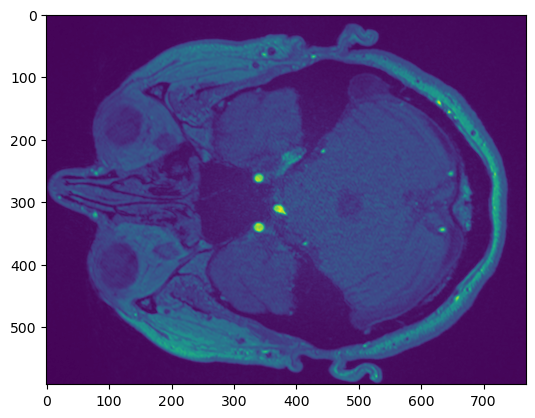

In [4]:
# read in one mri nifti file and print file and header
from preprocessing_utils import read_in_nifti
    
index = 0
data = read_in_nifti(MRI_file_list[index])

In [ ]:
# reads in one nii file and prints image and header
from preprocessing_utils import read_in_nrrd

index = 1
data = read_in_nrrd(MRI_file_list[index])

In [193]:
MRI_file_list[2]["nii"]

['/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_new/02453347_PG_Multiple/5 TOF_3D_1.nii.gz',
 '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_new/02453347_PG_Multiple/Segmentation_3.nii']

In [194]:
i = 1
print(MRI_file_list[i]['name'])
nii_img = nib.load(MRI_file_list[2]['nii'][0])

print(MRI_file_list_ex[i]['name'])
nii_img_ex = nib.load(MRI_file_list_ex[2]['nii'][3])

02053152-MCA-rechts-NEW
10002


In [195]:
print(nii_img.affine)
print(nib.affines.obliquity(nii_img.affine))

[[-2.95713872e-01 -1.23940837e-02 -4.67232615e-02  8.41883087e+01]
 [ 1.24018742e-02 -2.96615601e-01  7.75619468e-04  6.97416306e+01]
 [-2.31140982e-02 -5.83490939e-04  5.98177552e-01 -1.09292877e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[0.0884726  0.04180691 0.07796178]


In [196]:
print(nii_img_ex.affine)
print(nib.affines.obliquity(nii_img_ex.affine))

[[ -0.35714287   0.           0.         103.89599609]
 [  0.          -0.30153331  -0.26794028 105.98473358]
 [  0.          -0.19138622   0.42214596  14.65766716]
 [  0.           0.           0.           1.        ]]
[0.         0.56555137 0.56555137]


In [197]:
dict(nii_img.header)

{'sizeof_hdr': array(348, dtype=int32),
 'data_type': array(b'', dtype='|S10'),
 'db_name': array(b'', dtype='|S18'),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'regular': array(b'r', dtype='|S1'),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 512, 640, 190,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(512, dtype=int16),
 'bitpix': array(16, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1.      , 0.296875, 0.296875, 0.6     , 0.      , 0.      ,
        0.      , 0.      ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array(0., dtype=floa

In [198]:
dict(nii_img_ex.header)

{'sizeof_hdr': array(348, dtype=int32),
 'data_type': array(b'', dtype='|S10'),
 'db_name': array(b'', dtype='|S18'),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'regular': array(b'r', dtype='|S1'),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 560, 560, 140,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(16, dtype=int16),
 'bitpix': array(32, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1.        , 0.35714287, 0.35714287, 0.49999923, 0.        ,
        0.        , 0.        , 0.        ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array

In [202]:
new_voxel_size

(0.3, 0.3, 0.6)

In [204]:
def compute_new_dim(old_dims, old_vox, new_vox):
    assert len(old_dims)==len(old_vox) == len(new_vox)
    new_dim = [0]*len(old_dims)
    for i, (od, ov, nv) in enumerate(zip(old_dims, old_vox, new_vox)):
        new_dim[i] = int(od * (ov/nv))
    return new_dim

new_voxel_size = (0.3,0.3,0.6)

new_dim = compute_new_dim(nii_img.header["dim"][1:4], nii_img.header["pixdim"][1:4], new_voxel_size)
nii_new = conform(nii_img, voxel_size = new_voxel_size, out_shape = new_dim)
new_dim_ex = compute_new_dim(nii_img_ex.header["dim"][1:4], nii_img_ex.header["pixdim"][1:4], new_voxel_size )
nii_new_ex = conform(nii_img_ex, voxel_size = new_voxel_size, out_shape = new_dim_ex)

In [205]:
dict(nii_new.header)

{'sizeof_hdr': array(348, dtype=int32),
 'data_type': array(b'', dtype='|S10'),
 'db_name': array(b'', dtype='|S18'),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'regular': array(b'r', dtype='|S1'),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 506, 633, 190,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(512, dtype=int16),
 'bitpix': array(16, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1. , 0.3, 0.3, 0.6, 1. , 1. , 1. , 1. ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'sl

In [131]:
dict(nii_new_ex.header)

{'sizeof_hdr': array(348, dtype=int32),
 'data_type': array(b'', dtype='|S10'),
 'db_name': array(b'', dtype='|S18'),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'regular': array(b'r', dtype='|S1'),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 600, 600, 200,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(16, dtype=int16),
 'bitpix': array(32, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1. , 0.3, 0.3, 0.6, 1. , 1. , 1. , 1. ], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(2, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'sli

In [206]:
print(nii_new.affine)
print(nib.affines.obliquity(nii_new.affine))
print(nii_new_ex.affine)
print(nib.affines.obliquity(nii_new_ex.affine))


[[ 2.98826656e-01  1.25245475e-02 -4.67232583e-02 -7.47426237e+01]
 [-1.25324205e-02  2.99737866e-01  7.75619416e-04 -1.13559477e+02]
 [ 2.33574050e-02  5.89632940e-04  5.98177512e-01 -1.21469190e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[0.0884726  0.04180691 0.07796178]
[[  0.3          0.           0.         -95.70400629]
 [  0.           0.25328798  -0.32152885 -62.6969375 ]
 [  0.           0.16076442   0.50657596 -92.05102235]
 [  0.           0.           0.           1.        ]]
[0.         0.56555137 0.56555137]


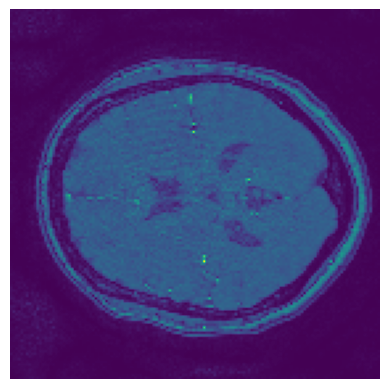

Gif saved under:  ext7.gif


In [208]:
animate_img(nii_img_ex.get_fdata(), save_path="ext7.gif")

In [7]:
import SimpleITK as sitk

# executes N4 bias field correction on the single image
def correct_bias(img_data):
    img_data_sitk = sitk.GetImageFromArray(img_data)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    #corrector.SetMaximumNumberOfIterations([5,5,5,5])
    #mask_image = sitk.OtsuThreshold(img_data, 0, 1, 200)
    corrected_image = sitk.GetArrayFromImage(corrector.Execute(img_data_sitk))
    log_bias_field = sitk.GetArrayFromImage(corrector.GetLogBiasFieldAsImage(img_data_sitk))
    
    return corrected_image, log_bias_field

nii_img = nib.load(MRI_file_list[1]['nii'][0])
nii_data = nii_img.get_fdata()

nii_data_corrected, log_bias_field = correct_bias(nii_data)

import pickle

with open('bias_files.pickle', 'wb') as f:
    pickle.dump((nii_data_corrected, log_bias_field), f, protocol=pickle.HIGHEST_PROTOCOL)

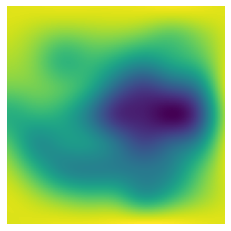

Gif saved under:  ../data_analysis/gifs/1664806996_gif.gif


In [10]:
import pickle
with open('bias_files.pickle', 'rb') as f:
    (nii_data_corrected, log_bias_field) = pickle.load(f)

from preprocessing_utils import animate_img
animate_img(log_bias_field)


## Correct Labels

In [73]:
path = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_new/04270916_VS_AComm/Segmentation_1.seg.nrrd'
data, header = nrrd.read(path)

label_list = read_classes_from_nrrd(path)

In [75]:
label_list['LabelValue']

0      1
1      2
2      3
4      4
5      5
6      6
7      7
8      8
9      9
3     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
Name: LabelValue, dtype: int64

In [ ]:
mapping = match_labels(label_list, class_table)

In [7]:
def read_classes_from_nrrd(path):
    data, header = nrrd.read(path)
    segment_keys = {}
    for key in header.keys():
        if key.startswith('Segment') and key[7].isdigit():
            segid, cont = key.split('_')
            index = int(segid[7:])
            if index not in segment_keys.keys():
                segment_keys[index] = {}
            segment_keys[index][cont] = header[key]

    label_list = pd.DataFrame.from_dict(segment_keys, orient='index')
    label_list = label_list[['Name', 'LabelValue']].astype({'LabelValue':int}).sort_values(by=['LabelValue'])
    label_list = label_list
    return label_list.rename(columns={'Name':'name', 'LabelValue':'label id'})


In [10]:
match_labels(file_classes, class_table)

{0: [1, 1, 'ICA', 'CA'],
 1: [2, 2, 'VA', 'VA'],
 2: [3, 3, 'BA', 'BA'],
 4: [5, 4, 'MCA-M1', 'MCA-M1'],
 5: [6, 5, 'MCA-M2', 'MCA-M2'],
 6: [7, 6, 'MCA-M3', 'MCA-M3'],
 3: [4, 7, 'Aneurysm', 'Aneurysm'],
 7: [8, 8, 'ACA-A1', 'ACA-A1'],
 8: [9, 9, 'ACA-A2', 'ACA-A2'],
 9: [10, 10, 'ACA-A3', 'ACA-A3'],
 10: [11, 11, 'AComm', 'AComm'],
 11: [12, 12, 'PComm', 'PComm'],
 12: [13, 13, 'PICA', 'PICA'],
 13: [14, 14, 'AICA', 'AICA'],
 14: [15, 15, 'SCA', 'SCA'],
 15: [16, 16, 'PCA-P1', 'PCA-P1'],
 16: [17, 17, 'PCA-P2', 'PCA-P2'],
 17: [18, 18, 'PCA-P3', 'PCA-P3'],
 18: [19, 19, 'Ophthalmic', 'Ophthalmic'],
 20: [21, 20, 'Choroidea', 'Choroidea'],
 19: [19, None, 'Fetal-PCA', None]}

In [11]:
# generates the label_assignments for all classes and saves them in extra file
from preprocessing_utils import match_labels

#ctbl = MRI_file['ctbl'][0]
path_to_class_labels_table = os.path.join(path_to_original, 'class_labels.xlsx')
class_table = pd.read_excel(path_to_class_labels_table)



for i in range(len(MRI_file_list)):
    print(i, MRI_file_list[i]['name'])
    seg_nrrd = [el for el in MRI_file_list[i]['nrrd'] if el.endswith('seg.nrrd')]
    if len(seg_nrrd) == 1:
        seg_file = seg_nrrd[0]
        
    else:
        seg_i = input(f'Give me the seg file: {MRI_file_list[i]["nrrd"]}')
        seg_file = MRI_file_list[i]['nrrd'][int(seg_i)]

    file_classes = read_classes_from_nrrd(seg_file)
    mapping = match_labels(file_classes, class_table)
    
    mapping_pd = pd.DataFrame.from_dict(mapping, orient='index')
    mapping_pd.columns = ['class_id', 'id_in_file', 'class_name', 'name_in_table']
    path = os.path.join(MRI_file_list[i]['path'], 'label_assignment2.csv')
    mapping_pd.to_csv(path, index=False)

0 02014629_KO_MCA
1 02053152-MCA-rechts-NEW
2 02453347_PG_Multiple
3 04270916_VS_AComm
4 05481872-AComm-new
5 06913083-MCA-NEW
6 06928064_SMK_MCA
7 07767625_LJ_Pericallosa
8 08016046-PComm-NEW_DONE
9 08211078_FS_MCA_NEW
10 10015183-MCA-new
11 10019209_EK_MCA
12 10083905_GLUK_MCA
13 10102066_KA_AComm
14 10104830_ZG_ComplexICA
15 10107525-MCA-new-Colors
16 10147148-AComm-NEW
17 10235145_SMHH_BA_MCA
18 10266790_CL_ICA
19 10293987_HMR_AComm
20 10299485_BMM_AComm_MCA
21 10448252_BPE_ICA
22 10480878_HS_PComm_MCA
23 10576901_KJ_ICA
24 10599468-AComm-new
25 10600633-AComm-new-Colors
26 10704331-AComm-NEW
27 10716885-AComm-NEW
28 10731124-MCA-rechts-NEW
29 10731286-ICA-links-NEW
30 10739823-PComm-links-NEW
31 10745241-MCA-new
32 10764179-MCA-NEW_DONE
33 10787757-ACA-NEW_DONE
34 10788543_ZM_MirrorMCA
35 10795198-BA-NEW_DONE
36 10795693_BE_PCA
37 10797356-VA-NEW
38 10799172_WH_MCA
39 10804920_ARS_MCA
40 10810765_EA_MCA
41 10811755_CC_AComm_NEW
42 10820130_MB_MirrorMCA
43 10854414_SS_MCA
44 108630

## Preprocessing
- convert file formats
- label correction
- reshaping, rescaling
- saving data and header into extra files

In [27]:
# converts all tof files from nrrd to nifti
from preprocessing_utils import convert_nrrd_to_nifti

for MRI_file in MRI_file_list:

    tof = []
    for nrrd_file in MRI_file['nrrd']:
        if 'tof' in nrrd_file.lower():
            tof.append(nrrd_file)
    if len(tof) == 0:
        print('Error: Could not find the correct nrrd TOF file')
        print('Files found: ', MRI_file['nrrd'])

    convert_nrrd_to_nifti(tof[0])

In [4]:
out_shape= (560, 640, 200)
voxel_size = (0.3, 0.3, 0.6)

In [ ]:
# Read through all MRI files, correct the labels and save them as extra files
from nibabel.processing import resample_to_output, conform
from preprocessing_utils import correct_labels, correct_bias

y_list = []
x_list = []

for mri_file in MRI_file_list:
    
    print(mri_file['name'])

    path_to_saved_y_file = os.path.join(path_to_raw_data, mri_file['name'] + '_y.npy')
    path_to_saved_x_file = os.path.join(path_to_raw_data, mri_file['name'] + '_x.npy')
    
    # Process Angiography TOF file (X)
    tof = []
    for nii_file in mri_file['nii']:
        if 'tof' in nii_file.lower():
            tof.append(nii_file)
    if len(tof) != 1:
        print('Error: Could not find the correct nrrd TOF file')
        print('Files found: ', tof)
    
    nii_x_img = nib.load(tof[0])

    nii_x_data = nii_x_img.get_fdata()

    #nii_x_data, _ = correct_bias(nii_x_data)

    nii_x_img = nib.Nifti1Image(nii_x_data, nii_x_img.affine, nii_x_img.header)

    # preprocessing data
    #nii_x_img = resample_to_output(nii_x_img, voxel_sizes=voxel_size, order = 3, mode = 'constant', cval=0)
    #nii_x_img = conform(nii_x_img, out_shape=out_shape, voxel_size=voxel_size, order=3, cval=0, orientation='RAS')

    with open(path_to_saved_x_file, 'wb') as f:
        np.save(f, nii_x_img.get_fdata())
    
    # Process Segmentation label file (Y)
    seg = []
    for nii_file in mri_file['nii']:
        if nii_file not in tof:
            seg.append(nii_file)
    if len(seg) != 1:
        print('Warning: Found multiple segmentation files')
        print('Files found: ', seg)
        
    nii_y_img = nib.load(seg[0])

    #nii_y_img = resample_to_output(nii_y_img, voxel_sizes=voxel_size, order = 0, mode = 'nearest', cval=0)
    #nii_y_img = conform(nii_y_img, out_shape=out_shape, voxel_size=voxel_size, order=0, cval=0, orientation='RAS')
    
    if any(nii_y_img.header['dim'] != nii_x_img.header['dim']):
        print('Warning: image and segmentation do not have the same dimensions. ', nii_y_img.header['dim'], nii_x_img.header['dim'])

    if any(nii_y_img.header['pixdim'] != nii_x_img.header['pixdim']):
        print('Warning: image and segmentation do not have the same voxel size. ', nii_y_img.header['pixdim'], nii_x_img.header['pixdim'])

    
    label_mapping = pd.read_csv(os.path.join(mri_file['path'], 'label_assignment.csv'), dtype={'class_id': int, 'id_in_file': float, 'class_name': str, 'name_in_table': str})
    # print mapping
    #label_mapping[['id_in_file', 'class_id']].dropna(axis='index', how='any').set_index('id_in_file').to_dict()['class_id']
    
    nii_y_data_corr = correct_labels(nii_y_img.get_fdata(), label_mapping)
    with open(path_to_saved_y_file, 'wb') as f:
        np.save(f, nii_y_data_corr)
        

In [24]:
MRI_file_list[0]

{'name': '10001',
 'path': '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001',
 'nii': ['/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001/aneurysms.nii.gz',
  '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001/pre/struct_aligned.nii.gz',
  '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001/pre/struct.nii.gz',
  '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001/pre/TOF.nii.gz'],
 'nrrd': [],
 'vtk': [],
 'ctbl': []}

In [ ]:
# Read through all MRI files, extracts and saves headers

y_list_headers = []
x_list_header = []

for mri_file in MRI_file_list:
    
    print(mri_file['name'])

    path_to_saved_y_header = os.path.join(path_to_headers, mri_file['name'] + '_y.json')
    path_to_saved_x_header = os.path.join(path_to_headers, mri_file['name'] + '_x.json')
    
    # Process Angiography TOF file (X)
    tof = []
    for nii_file in mri_file['nii']:
        if 'tof' in nii_file.lower():
            tof.append(nii_file)
    if len(tof) != 1:
        print('Error: Could not find the correct nii TOF file')
        print('Files found: ', tof)
    
    nii_x_img = nib.load(tof[0])
    nii_x_header = nii_x_img.header
    x_list_header.append(dict(nii_x_header))
    
    json_object = pd.Series(nii_x_header).to_json()
    with open(path_to_saved_x_header, 'w') as f:
        f.write(json_object)
    
    # Process Segmentation label file (Y)
    seg = []
    for nii_file in mri_file['nii']:
        if nii_file not in tof and "aneurysms" in nii_file:
            seg.append(nii_file)
    if len(seg) != 1:
        print('Warning: Found multiple segmentation files')
        print('Files found: ', seg)
        
    nii_y_img = nib.load(seg[0])
    nii_y_header = nii_y_img.header
    y_list_headers.append(dict(nii_y_header))

    json_object = pd.Series(nii_y_header).to_json()
    with open(path_to_saved_y_header, 'w') as f:
        f.write(json_object)

## Data Analysis
- read in preprocessed data
- analyse distribution of
    - labels
    - resolution
    - voxel size

In [15]:
x_headers, y_headers = x_list_header, y_list_headers
voxel_volumes = [h["pixdim"][1:4] for h in x_headers]

In [ ]:
from preprocessing_utils import read_header_data

x_headers, y_headers, voxel_volumes = read_header_data(path_to_headers)

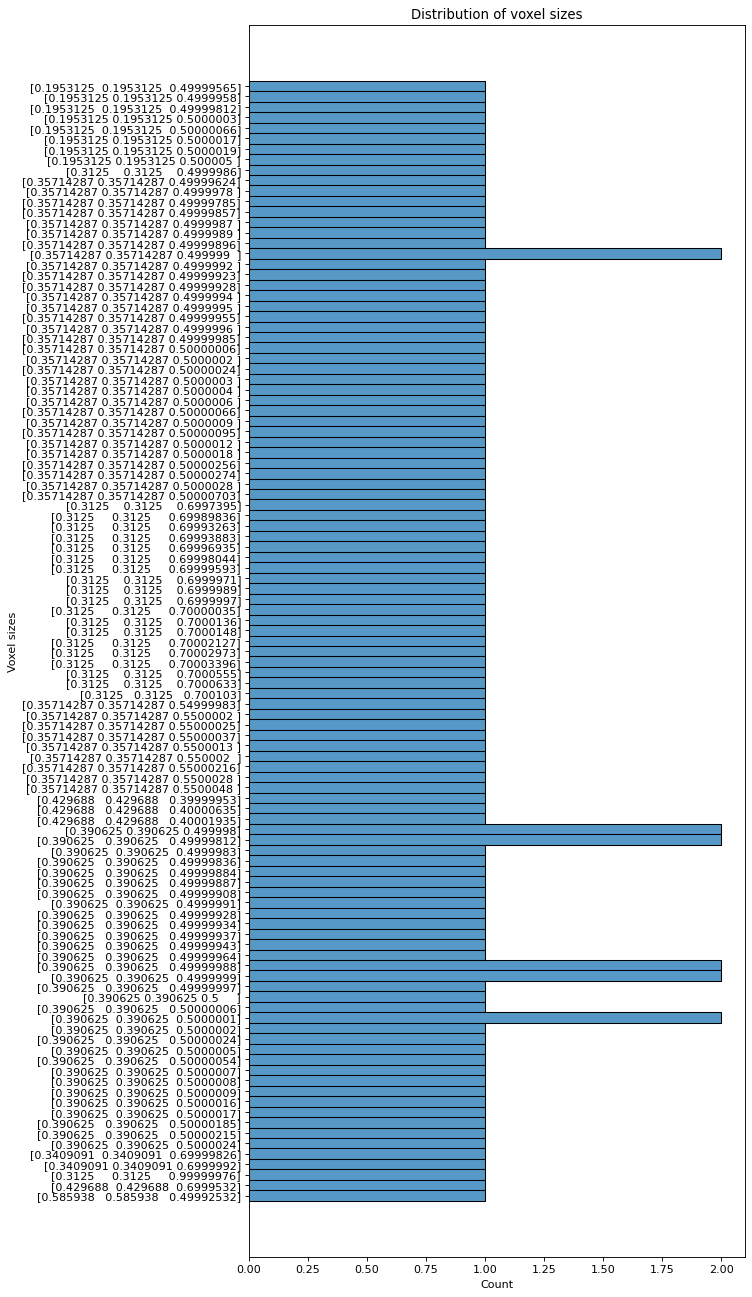

In [19]:
# Analyses headers / voxel sizes

# plots distribution of Voxel sizes, ordered by voxel volume size
voxel_volumes = np.array(voxel_volumes)
sorted_voxel_volumes = voxel_volumes[np.argsort(np.prod(voxel_volumes, axis=1))]

fig = plt.figure(figsize=(8, 20), dpi=80)
ax = sns.histplot(np.prod(voxel_volumes, axis=1), y = [str(el) for el in sorted_voxel_volumes])
ax.set_ylabel('Voxel sizes')
ax.set_title('Distribution of voxel sizes')
fig.savefig(os.path.join(path_to_data_analysis, 'voxel_size_hist.png'), bbox_inches='tight')


In [3]:
# reads in volume data

x,y = read_data_names(path_to_new_processed_data)

Error:  file_dict.csv


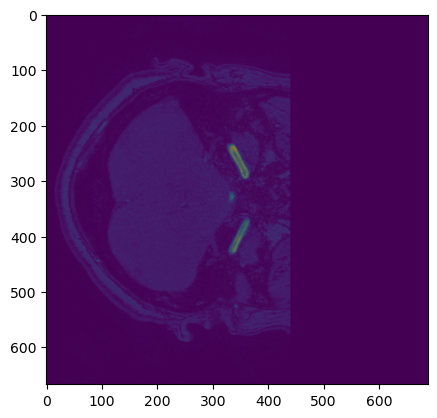

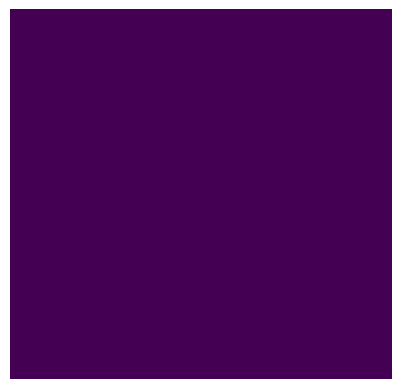

Gif saved under:  ext.gif


In [28]:
index = 2 
slice = 100

reader_image = h5py.File(os.path.join(path_to_new_processed_data, x[index]), 'r')
reader_target = h5py.File(os.path.join(path_to_new_processed_data, y[index]), 'r')

data_x = reader_image['data'][()]
data_y = reader_target['data'][()]
plt.imshow(data_x[:,:,slice])
plt.imshow(data_y[:,:,slice], alpha=0.5)
animate_img(data_x, "/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_analysis")

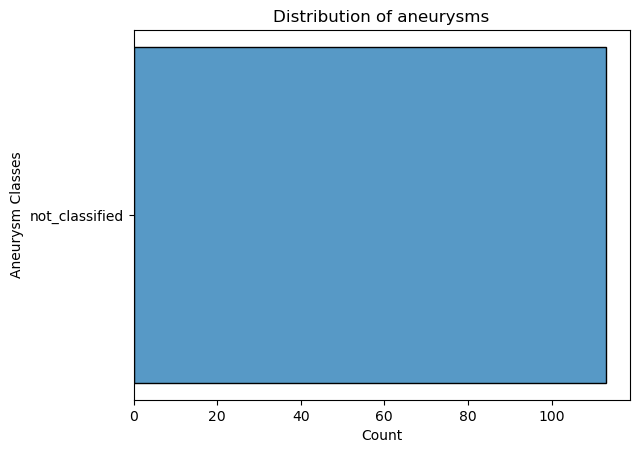

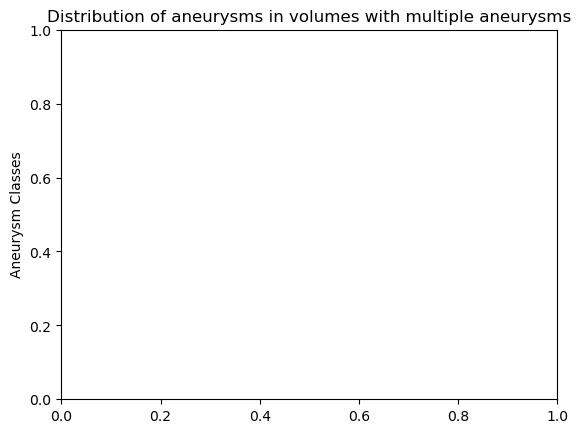

In [15]:
# Analyse the distribution of labels

# possible aneurysm classes, given by Elisa
aneurysm_classes = ['mca', 'acomm', 'ica', 'pcomm', 'pica', 'aca', 'pca', 'ba', 'va', 'multiple', 'not_classified']

class_per_scan = dict()
class_per_scan_multiple = dict()

# Reads out classes per volume

for scan in x:
    prevalent_classes = [a_class for a_class in aneurysm_classes if a_class in scan.lower()]
    if len(prevalent_classes) == 1:
        class_per_scan[scan] = prevalent_classes[0]
    elif len(prevalent_classes) >= 1:
        class_per_scan[scan] = 'multiple'
        class_per_scan_multiple[scan] = prevalent_classes
    else: #len(prevalent_classe) == 1
        class_per_scan[scan] = 'not_classified'
        
classes_in_data = [el[1] for el in class_per_scan.items()]

# Plot the distribution of aneurysm classes
fig1 = plt.figure()
ax1 = sns.histplot(classes_in_data, y = classes_in_data)
ax1.set_ylabel('Aneurysm Classes')
ax1.set_title('Distribution of aneurysms')
fig1.savefig(os.path.join(path_to_data_analysis, 'label_hist.png'), bbox_inches='tight')

# Plot the distribution of aneuriysm classes in volumes with multiple aneurysm
fig2 = plt.figure()
classes_in_data_multiple = [str(el[1]) for el in class_per_scan_multiple.items()]
ax2 = sns.histplot(classes_in_data_multiple, y = classes_in_data_multiple)
ax2.set_ylabel('Aneurysm Classes')
ax2.set_title('Distribution of aneurysms in volumes with multiple aneurysms')
fig2.savefig(os.path.join(path_to_data_analysis, 'label_hist_multiple.png'), bbox_inches='tight')



Text(0.5, 1.0, 'Distribution of resolution')

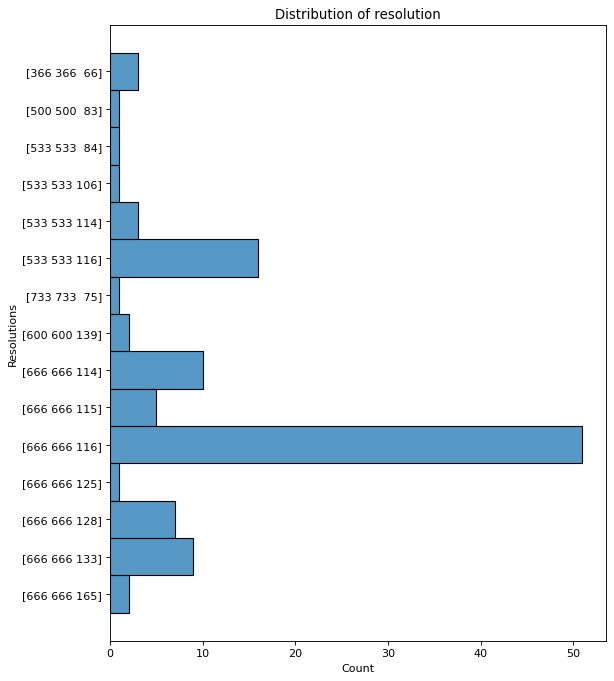

In [6]:
resolution_per_scan = dict()
data_path = path_to_new_processed_data
for i in range(len(x)):
    #x_data = np.load(os.path.join(data_path,x[i]))
    reader_image = h5py.File(os.path.join(data_path,x[i]), 'r')
    x_data = reader_image['data'][()]

    #y_data = np.load(os.path.join(data_path,y[i]))
    resolution_per_scan[x[i]] = x_data.shape

resolutions_in_data = np.array([el[1] for el in resolution_per_scan.items()])
_sorting = np.argsort(np.prod(resolutions_in_data, axis=1))
sorted_resolutions = resolutions_in_data[_sorting]

fig3 = plt.figure(figsize=(8, 10), dpi=80)
ax3 = sns.histplot(np.prod(sorted_resolutions, axis=1), y = [str(el) for el in resolutions_in_data[_sorting]])
ax3.set_ylabel('Resolutions')
ax3.set_title('Distribution of resolution')

#fig3.savefig(os.path.join(path_to_data_analysis, 'resolution_hist_vox_normalized.png'), bbox_inches='tight')


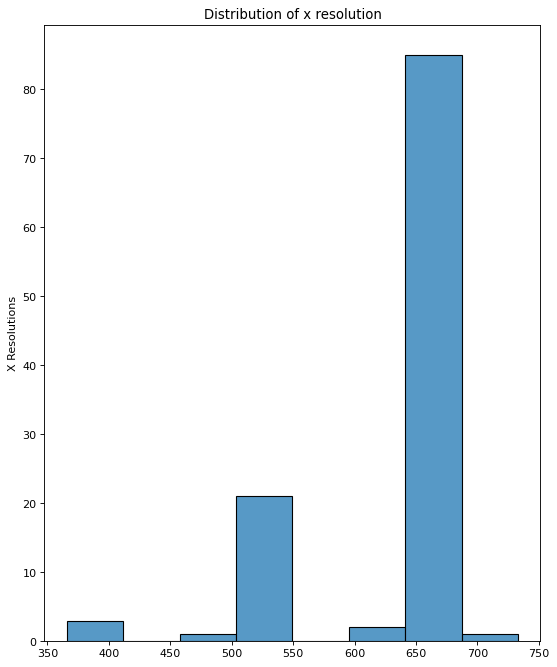

In [9]:
x_resolutions = [el[0] for el in resolutions_in_data]
fig3 = plt.figure(figsize=(8, 10), dpi=80)
ax3 = sns.histplot(x_resolutions)
ax3.set_ylabel('X Resolutions')
ax3.set_title('Distribution of x resolution')
fig3.savefig(os.path.join(path_to_data_analysis, 'resolution_x_hist_vox_normalized.png'), bbox_inches='tight')

In [23]:
i = np.argsort(np.prod(resolutions_in_data, axis=1))
resolutions_in_data[i[-10:]]
print(np.array(list(resolution_per_scan.items()))[i[-10:]], i[-10:])

# choose ['10811755_CC_AComm_NEW_x.npy' (667, 667, 188)] (index=41) for registration

[['10795693_BE_PCA_x.npy' (587, 734, 184)]
 ['11047954_LM_Pericallosa_x.npy' (587, 734, 184)]
 ['10293987_HMR_AComm_x.npy' (667, 667, 180)]
 ['10102066_KA_AComm_x.npy' (667, 667, 184)]
 ['10147148-AComm-NEW_x.npy' (667, 667, 184)]
 ['10820130_MB_MirrorMCA_x.npy' (667, 667, 184)]
 ['10019209_EK_MCA_x.npy' (667, 667, 184)]
 ['60213089-MCA-ICA-NEW_x.npy' (667, 667, 184)]
 ['10811755_CC_AComm_NEW_x.npy' (667, 667, 188)]
 ['10896074_BRE_AComm_ICA_x.npy' (555, 634, 239)]] [36 51 19 13 16 42 11 61 41 45]


/tmp/ipykernel_12425/3807681156.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(list(resolution_per_scan.items()))[i[-10:]], i[-10:])


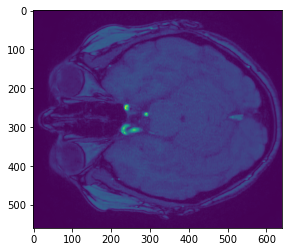

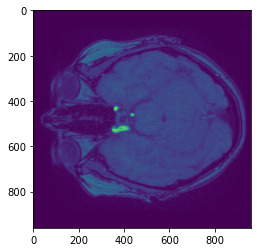

In [187]:
# Look at the image with the highest resolution and resize (number 41, 10811755_CC_AComm_NEW, (960,960,204))
out_shape= (560,640, 200)
voxel_size = (0.3, 0.3, 0.6)


nii_img = nib.load(MRI_file_list[41]['nii'][0])

nii_img_new = resample_to_output(nii_img, voxel_sizes=voxel_size, order = 3, mode = 'constant', cval=0)
nii_img_new = conform(nii_img_new, out_shape=out_shape, voxel_size=voxel_size, order=3, cval=0, orientation='RAS')



plt.figure()
plt.imshow(nii_img_new.get_fdata()[:,:,100])


plt.figure()
plt.imshow(nii_img.get_fdata()[:,:,100])

In [12]:
# Look at intensity distribution
from matplotlib.pyplot import figure
data_path = path_to_new_processed_data

all_characteristics = []
all_mean = []
for i in range(len(x)):
    reader_image = h5py.File(os.path.join(data_path,x[i]), 'r')
    x_data = reader_image['data'][()]
    #y_data = np.load(os.path.join(path_to_raw_data,y[i]))
    _dist_characteristics = {
            "Name" : x[i][:-6],
            "Mean": np.mean(x_data),
            "Var": np.var(x_data),
            "Median" : np.median(x_data),
            "Min" : np.min(x_data),
            "Max" : np.max(x_data),
            "95 Percentile" : np.percentile(x_data, 95),
            "5 Percentile" : np.percentile(x_data, 5),
            "Max - Min" : np.max(x_data) - np.min(x_data)
        }

    all_characteristics.append(_dist_characteristics)
characteristic_names = all_characteristics[0].keys()



In [10]:
pd.DataFrame(all_characteristics).to_csv('/scratch/lhauptmann/segmentation_3D/data_analysis/data_characteristics.csv')

In [13]:
all_characteristics = pd.read_csv('/scratch/lhauptmann/segmentation_3D/data_analysis/data_characteristics.csv')

In [14]:
all_characteristics.head()

,Unnamed: 0,Mean,Median,Min,Max,95 Percentile,5 Percentile,Max - Min
0,0,110.776696,109.000000,0.000000,1509.000000,295.000000,13.000000,1509.000000
1,1,199.620292,227.000000,-76.000000,2861.000000,417.000000,0.000000,2937.000000
2,2,86.742661,94.000000,0.000000,1251.000000,191.000000,11.000000,1251.000000
3,3,185.274967,139.861779,-19.969071,2818.551408,456.313804,0.090772,2838.520478
4,4,75.420770,75.000000,0.000000,1424.000000,170.000000,10.000000,1424.000000


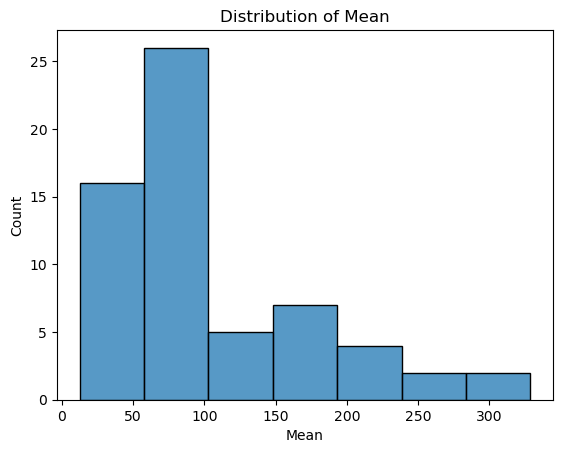

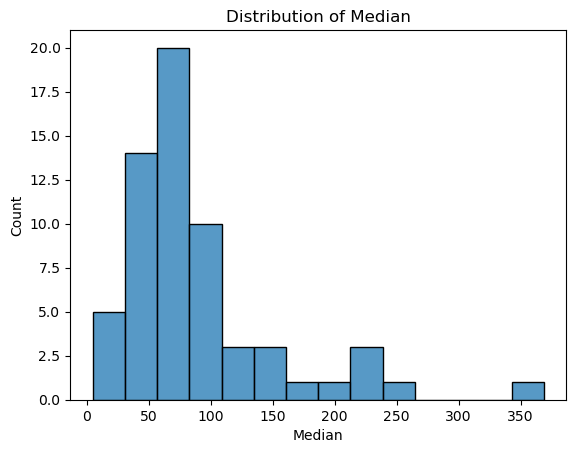

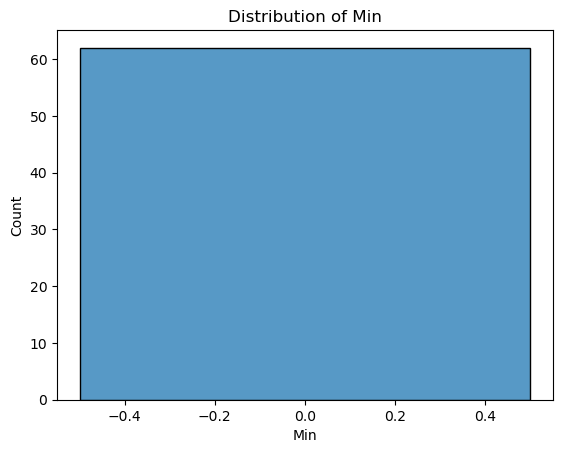

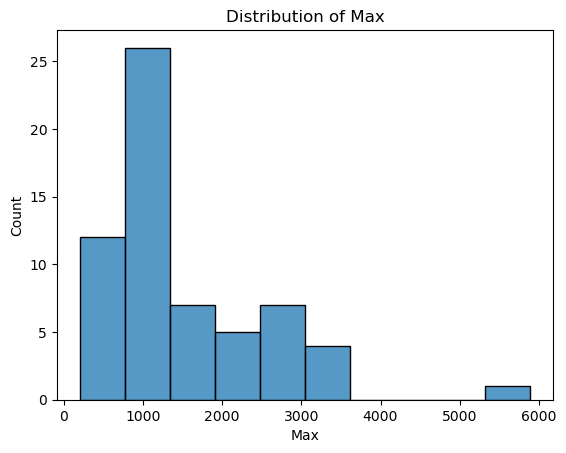

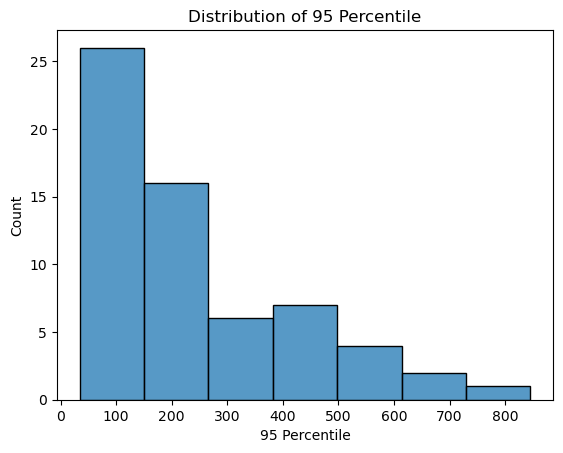

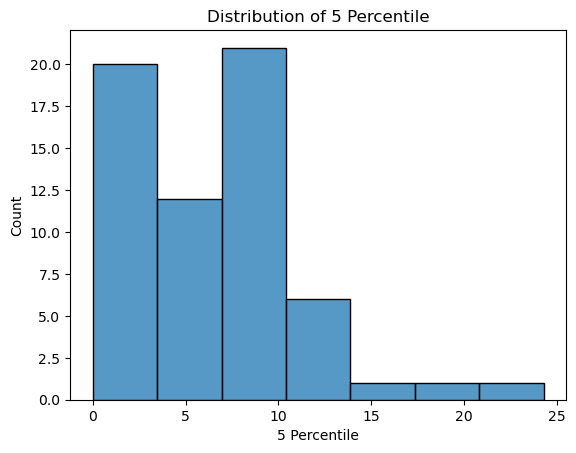

In [36]:

for i, name in enumerate(characteristic_names):
    fig = plt.figure()
    _values = [el[name] for el in all_characteristics]
    #print(_values)
    ax = sns.histplot(_values)
    ax.set_xlabel(name)
    ax.set_ylabel("Count")
    ax.set_title("Distribution of " + name)
    fig.savefig(os.path.join(path_to_data_analysis, 'intensity_distribution_' + name +  '.png'), bbox_inches='tight')

In [23]:
def rescale_loc(labels, shape):
    labels_rescaled = np.zeros_like(labels, dtype=np.float)
    for i in range(labels.shape[0]):
        labels_rescaled[i,0] = float(labels[i,0])/float(shape[0])
        labels_rescaled[i,1] = float(labels[i,1])/float(shape[1])
        labels_rescaled[i,2] = float(labels[i,2])/float(shape[2])
    return labels_rescaled

all_labels = []
target_label = 4

for i in range(len(x)):
    #x_data = np.load(os.path.join(path_to_external_data,x[i]))
    y_data = np.load(os.path.join(path_to_external_data,y[i]))
    labels = np.transpose((y_data==target_label).nonzero())
    labels = rescale_loc(labels, y_data.shape).tolist()

    all_labels.extend(labels)

x_l = [el[0] for el in all_labels]
y_l = [el[1] for el in all_labels]
z_l = [el[2] for el in all_labels]

/tmp/ipykernel_15632/3998048268.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_rescaled = np.zeros_like(labels, dtype=np.float)


In [24]:
labels_array = np.asarray(all_labels)
hist = np.histogramdd(labels_array, bins=100, density=True)

In [39]:
cov = np.cov(labels_array, rowvar=False)
mean = np.mean(labels_array, axis=0)

In [32]:
cov

array([[ 0.00374039,  0.0006371 , -0.00230125],
       [ 0.0006371 ,  0.00390621, -0.00504554],
       [-0.00230125, -0.00504554,  0.01874314]])

In [40]:
mean

array([0.49534774, 0.45378317, 0.45682052])

In [44]:
np.save(os.path.join(path_to_data_analysis, 'location_gaussian_cov.npy'), cov)

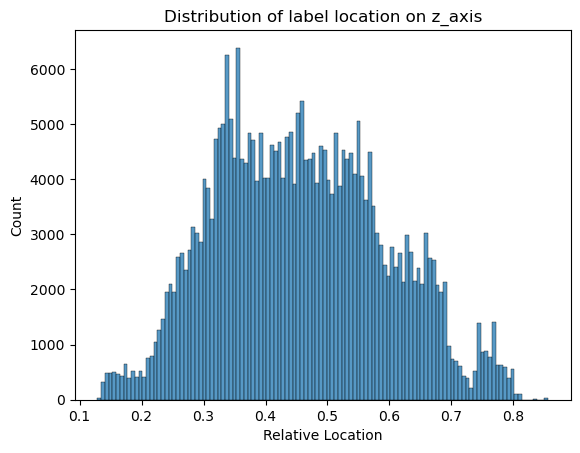

In [72]:
fig = plt.figure()
ax = sns.histplot([el[2] for el in all_labels])
ax.set_xlabel("Relative Location")
ax.set_ylabel("Count")
ax.set_title("Distribution of label location on z_axis")
fig.savefig(os.path.join(path_to_data_analysis, 'label_location_z.png'), bbox_inches='tight')

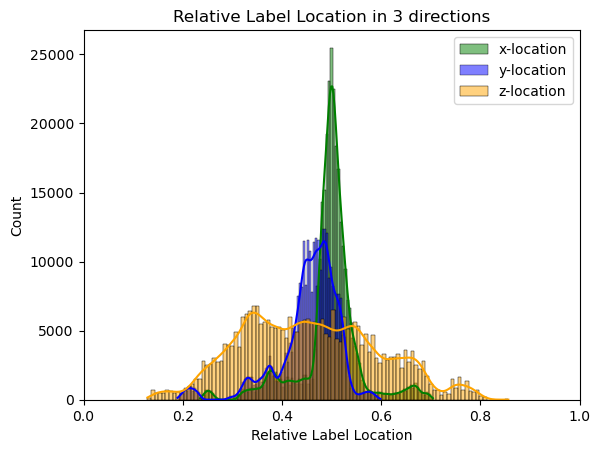

In [84]:
fig = plt.figure()
sns.histplot(x_l, label='x-location', color="green",bins=100, kde=True)
sns.histplot(y_l, label='y-location', color="blue",bins=100, kde=True)
sns.histplot(z_l , label='z-location', color="orange", bins=100, kde=True)
plt.legend()
plt.xlabel('Relative Label Location')
plt.ylabel('Count')
plt.title('Relative Label Location in 3 directions')
plt.xlim(0,1)
fig.savefig(os.path.join(path_to_data_analysis, 'label_location_xyz.png'), bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

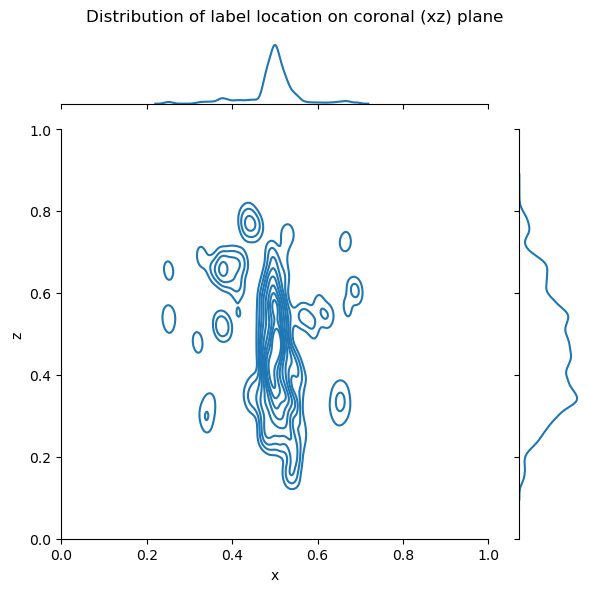

In [103]:
all_labels_df = pd.DataFrame(data=all_labels, columns=("x", "y", "z"))
fig = plt.figure()
ax = sns.jointplot(data=all_labels_df,x="x", y="z", kind = 'kde', xlim=(0,1), ylim=(0,1), )

plt.gcf().suptitle("Distribution of label location on coronal (xz) plane")
plt.tight_layout()
ax.savefig(os.path.join(path_to_data_analysis, 'label_location_xz.png'), bbox_inches='tight')

## Data splitting
- Splitting the data for training
- Writing the splits into a dict

In [14]:
# reads in volume data
path = path_to_new_processed_data
x,y = read_data_names(path, keep_ending=False)

In [17]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
path = path_to_new_processed_data
x,y = read_data_names(path, keep_ending=False)
classes_in_data = np.array(classes_in_data)
k_fold_dict = dict() # saves the splits per dict
sss = StratifiedKFold(n_splits=10)
train_index, test_index = next(sss.split(x,classes_in_data))
x_train, x_test = x[train_index], x[test_index]
y_train, y_test = y[train_index], y[test_index]
classes_in_data_train, classes_in_data_test = classes_in_data[train_index], classes_in_data[test_index]

skf = StratifiedKFold(n_splits=9)
for i, (train_index, test_index) in enumerate(skf.split(x_train, classes_in_data_train)):
    x_train_k, x_val_k = x_train[train_index], x_train[test_index]
    y_train_k, y_val_k = y_train[train_index], y_train[test_index]
    dict_per_split = {'x_train': x_train_k,
                    'x_test': x_test,
                    'y_train': y_train_k,
                    'y_test': y_test,
                    'x_val': x_val_k,
                    'y_val' : y_val_k}
    k_fold_dict[i] = dict_per_split



In [20]:

json_object = pd.DataFrame(k_fold_dict).to_json()
with open(os.path.join(path_to_data_splits, 'k_fold_split4_val.json'), 'w') as f:
    f.write(json_object)


In [19]:
k_fold_dict = pd.read_json(os.path.join(path_to_data_splits, 'k_fold_split4_val.json'))

ValueError: Expected object or value

## Data copying

In [5]:
# reads in volume data
x,y = read_data_names(path_to_external_data)

In [6]:
import shutil
for i,x in enumerate(k_fold_dict[0]['x_train']):
    y = k_fold_dict[0]['y_train'][i]
    shutil.copy(os.path.join(path_to_processed_data, x), os.path.join("../data/USZ_BrainArtery_processed_split/train/", x))
    shutil.copy(os.path.join(path_to_processed_data, y), os.path.join("../data/USZ_BrainArtery_processed_split/train/", y))

In [7]:
import shutil
for i,x in enumerate(k_fold_dict[0]['x_test']):
    y = k_fold_dict[0]['y_test'][i]
    shutil.copy(os.path.join(path_to_processed_data, x), os.path.join("../data/USZ_BrainArtery_processed_split/test/", x))
    shutil.copy(os.path.join(path_to_processed_data, y), os.path.join("../data/USZ_BrainArtery_processed_split/test/", y))

In [8]:
import shutil
for i,x in enumerate(k_fold_dict[0]['x_val']):
    y = k_fold_dict[0]['y_val'][i]
    shutil.copy(os.path.join(path_to_processed_data, x), os.path.join("../data/USZ_BrainArtery_processed_split/val/", x))
    shutil.copy(os.path.join(path_to_processed_data, y), os.path.join("../data/USZ_BrainArtery_processed_split/val/", y))

In [16]:
for fold in range(k_fold_dict.shape[1]):
    fold_dir = os.path.join(path_to_external_data,'folds/', str(1))
    if not os.path.exists(fold_dir):
        os.mkdir(fold_dir)

    for dir in ['train/', 'test/', 'val/']:
        path_dir = os.path.join(fold_dir, dir)
        if not os.path.exists(path_dir):
            os.mkdir(path_dir)
        
    for i,x in enumerate(k_fold_dict[fold]['x_test']):
        y = k_fold_dict[fold]['y_test'][i]
        shutil.copy(os.path.join(path_to_processed_data, x), os.path.join(fold_dir,'test/', x))
        shutil.copy(os.path.join(path_to_processed_data, y), os.path.join(fold_dir,'test/', y))

    for i,x in enumerate(k_fold_dict[fold]['x_train']):
        y = k_fold_dict[fold]['y_train'][i]
        shutil.copy(os.path.join(path_to_processed_data, x), os.path.join(fold_dir,'train/', x))
        shutil.copy(os.path.join(path_to_processed_data, y), os.path.join(fold_dir,'train/', y))

    for i,x in enumerate(k_fold_dict[fold]['x_val']):
        y = k_fold_dict[fold]['y_val'][i]
        shutil.copy(os.path.join(path_to_processed_data, x), os.path.join(fold_dir,'val/', x))
        shutil.copy(os.path.join(path_to_processed_data, y), os.path.join(fold_dir,'val/', y))



## Data Plotting


In [ ]:
for i in range(len(x)):
    x_data = np.load(os.path.join(path_to_processed_data,x[i]))
    y_data = np.load(os.path.join(path_to_processed_data,y[i]))

    save_path_x = os.path.join(path_to_data_analysis, 'data_img', x[i][:-4] + '.png')
    save_path_y = os.path.join(path_to_data_analysis, 'data_img', y[i][:-4] + '.png')

    fig_x = plt.figure()
    plt.imshow(x_data[:,:,int(x_data.shape[2]/2)])
    plt.savefig(save_path_x)
    plt.axis('off')

    fig_y = plt.figure()
    plt.imshow(y_data[:,:,int(y_data.shape[2]/2)])
    plt.savefig(save_path_y)
    plt.axis('off')



In [ ]:
for i in range(len(x)):
    print(i)
    x_data = np.load(os.path.join(path_to_processed_data,x[i]))
    y_data = np.load(os.path.join(path_to_processed_data,y[i]))

    save_path_x = os.path.join(path_to_data_analysis, 'data_gif', x[i][:-4] + '.gif')
    save_path_y = os.path.join(path_to_data_analysis, 'data_gif', y[i][:-4] + '.gif')

    animate_img(x_data, size='small', path_to_data_analysis = "../data_analysis/", save_path= save_path_x)
    animate_img(y_data, size='small', path_to_data_analysis = "../data_analysis/", save_path= save_path_y)

    

In [ ]:
for i in range(len(x)):
    print(i)
    x_data = np.load(os.path.join(path_to_processed_bias_data,x[i]))
    y_data = np.load(os.path.join(path_to_processed_bias_data,y[i]))

    save_path_x = os.path.join(path_to_data_analysis, 'data_biasr_gif', x[i][:-4] + '.gif')
    save_path_y = os.path.join(path_to_data_analysis, 'data_biasr_gif', y[i][:-4] + '.gif')

    animate_img(x_data, size='small', path_to_data_analysis = "../data_analysis/", save_path= save_path_x)
    animate_img(y_data, size='small', path_to_data_analysis = "../data_analysis/", save_path= save_path_y)

    save_path_x = os.path.join(path_to_data_analysis, 'data_biasr_img', x[i][:-4] + '.png')
    save_path_y = os.path.join(path_to_data_analysis, 'data_biasr_img', y[i][:-4] + '.png')

    fig_x = plt.figure()
    plt.imshow(x_data[:,:,int(x_data.shape[2]/2)])
    plt.savefig(save_path_x)
    plt.axis('off')

    fig_y = plt.figure()
    plt.imshow(y_data[:,:,int(y_data.shape[2]/2)])
    plt.savefig(save_path_y)
    plt.axis('off')

In [ ]:
# reads in volume data
x,y = read_data_names(path_to_data, keep_ending=True)

for i in range(len(x)):
    print(i)
    x_data = np.load(os.path.join(path_to_data,x[i])).flatten()
    fig = plt.figure()
    save_path_x = os.path.join(path_to_data_analysis, 'data_hist', x[i][:-4] + '.png')
    ax = sns.histplot(x_data[x_data.nonzero()], log_scale=(False, True))
    ax.set_xlabel('Intensity')
    ax.set_ylabel("Count")
    ax.set_xlim(0,3e3)
    ax.set_ylim(0,1e7)
    ax.set_title("Distribution of Intensity")
    fig.savefig(save_path_x, bbox_inches='tight')



In [54]:
img = np.load(os.path.join(path_to_external_data, x[15]))
target = np.load(os.path.join(path_to_external_data, y[15]))
#target = np.where(target==4, 4, 0)

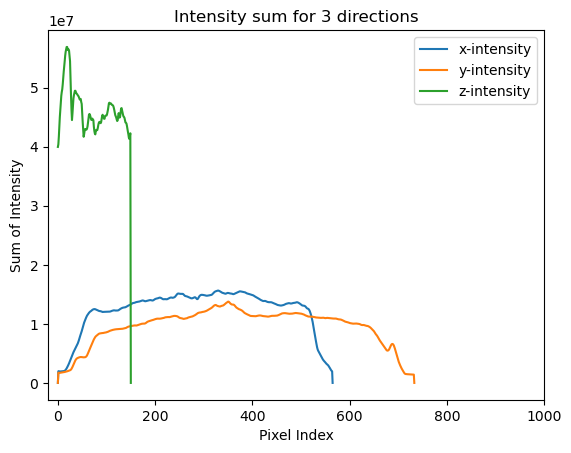

In [23]:
def integrate_intensity(img, save_path=None):
    inten_x = np.sum(img, axis=(1,2))
    inten_y = np.sum(img, axis=(0,2))
    inten_z = np.sum(img, axis=(0,1))

    plt.plot(inten_x, label='x-intensity')
    plt.plot(inten_y, label='y-intensity')
    plt.plot(inten_z, label='z-intensity')
    #plt.yscale('log')
    plt.legend()
    plt.xlabel('Pixel Index')
    plt.ylabel('Sum of Intensity')
    plt.title('Intensity sum for 3 directions')
    plt.xlim(-20,1000)
    plt.show()
    if save_path != None:
        plt.savefig(save_path)

for x_file in x:
    img = np.load(os.path.join(path_to_external_data, x_file))
    save_path = os.path.join('/scratch/lhauptmann/BrainSeg/data_analysis/data_intensities', x_file + '.png')
    integrate_intensity(img, save_path)

In [11]:
x,y = read_data_names(path_to_external_data, keep_ending=False)
for i in range(len(y)):
    y_data = np.load(os.path.join(path_to_external_data,y[i]))

    save_path_y = os.path.join(path_to_data_analysis, 'data_img', y[i] + '.png')



SyntaxError: invalid syntax (1364351945.py, line 1)

In [15]:
y_data = np.load(os.path.join(path_to_external_data,y[0]))

In [14]:
y_data.shape

(566, 734, 151)

In [12]:
import shutil
import time
path = "/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ_BrainArtery/unlabelled"
for dir in os.listdir(path):
    time_str = str(int(time.time()))
    old_name = os.path.join(path, dir)
    new_name = old_name.replace("Neue TOFs ohne Labels", time_str)
    os.rename(old_name, new_name)

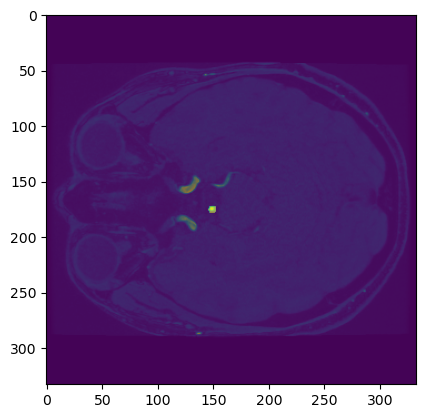

In [4]:
x_path = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_hdf5d/data/10299485_BMM_AComm_MCA_x.h5"
y_path = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_hdf5d/data/10299485_BMM_AComm_MCA_y.h5"

x = read_h5(x_path)
y = read_h5(y_path)

plot_overlay(x,y==4,100, alpha=0.5)

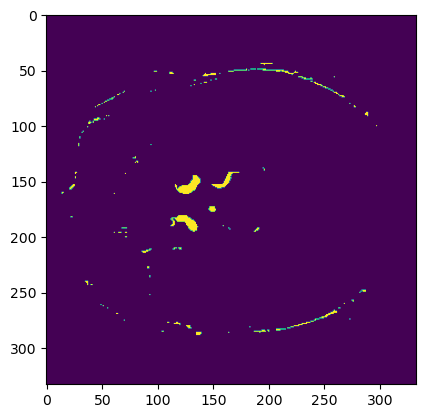

In [23]:
plt.imshow((x > np.percentile(x,99))[:,:,100])

In [48]:
def find_first_threshold_loc(img, threshold,  axis = 0 ,smooth=1 , backwards=False):
    assert axis in [0,1,2]
    if backwards==False:
        iter_list = list(range(img.shape[axis]))
    else:
        iter_list = list(range(img.shape[axis]))[::-1]
    if axis == 0:
        for loc in iter_list:
            if torch.sum(img[loc, :,:] > threshold) >= smooth:
                return loc
    elif axis == 1:
        for loc in iter_list:
            if torch.sum(img[:, loc,:] > threshold) >= smooth:
                return loc
    elif axis == 2:
        for loc in iter_list:
            if torch.sum(img[:,:, loc] > threshold) >= smooth:
                return loc
    return -1

def crop_till_threshold(img, threshold, axes = ["x", "y", "z"], smooth = 1):
    threshold_locs = {}
    for ax in axes:
        if ax == "x":
            threshold_locs[ax] = (find_first_threshold_loc(img, threshold, axis=0, smooth=smooth,backwards=False), find_first_threshold_loc(img, threshold, axis=0, smooth=smooth,backwards=True))
        elif ax =="y":
            threshold_locs[ax] = (find_first_threshold_loc(img, threshold, axis=1, smooth=smooth,backwards=False), find_first_threshold_loc(img, threshold, axis=1, smooth=smooth,backwards=True))
        elif ax =="z":
            threshold_locs[ax] = (find_first_threshold_loc(img, threshold, axis=2, smooth=smooth,backwards=False), find_first_threshold_loc(img, threshold, axis=2, smooth=smooth,backwards=True))

    return threshold_locs

    
x_torch = torch.Tensor(x)
crop_till_threshold(x_torch, np.percentile(x_torch.flatten(), 99), smooth=1)

{'x': (43, 290), 'y': (7, 314), 'z': (1, 152)}

In [49]:
crop_till_threshold(x_torch, np.percentile(x_torch.flatten(), 99), smooth=1)

{'x': (42, 290), 'y': (5, 323), 'z': (0, 152)}

In [50]:
x_torch.shape

torch.Size([333, 333, 154])

In [39]:
volumes = sorted(list(os.listdir(path_to_processed_bias_data)))
volumes = [os.path.join(path_to_processed_bias_data, el) for el in volumes]
volumes_adam = sorted(list(os.listdir(path_to_new_processed_data)))
volumes_adam = [os.path.join(path_to_new_processed_data, el) for el in volumes_adam]
import nilearn

In [53]:
x = volumes[0]
y = volumes[1]

In [62]:
x,y

('/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_x.nii.gz',
 '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_y.nii.gz')

In [142]:
x = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Sharing/ADAM_Challenge/ADAM_release_subjs/10001/pre/struct.nii.gz'
x = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_x.nii.gz'

In [122]:
x_img = nib.load(x)

In [129]:
x_data = x_img.get_fdata()

In [130]:
x_data = x_data * (65535/1470)

In [127]:
x_img.get_fdata().max()

1470.7870054710656

sizeof_hdr should be 540; set sizeof_hdr to 540


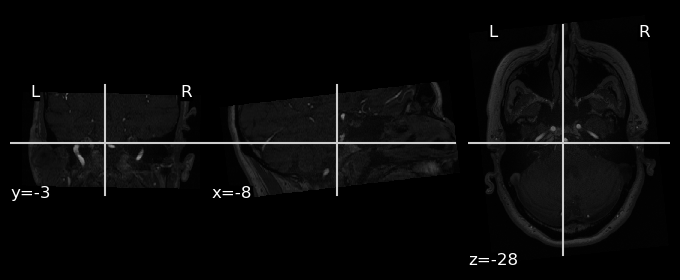

In [132]:
nilearn.plotting.plot_anat(nib.Nifti2Image(x_data, x_img.affine, x_img.header))

In [97]:
mask_img = nilearn.masking.compute_brain_mask(x, threshold=0.4)

In [140]:
epi_mask_img = nilearn.masking.compute_epi_mask(x)

In [134]:
fsl_mask_img = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_x_be02.nii.gz'

In [81]:
mask_img = nib.load(mask_img)

In [82]:
data = mask_img.get_fdata()

In [83]:
data.shape

(592, 768, 150)

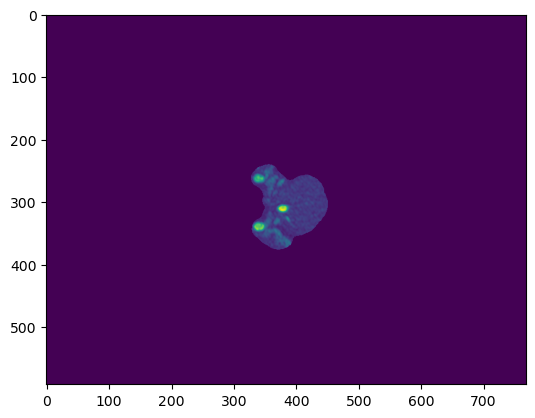

In [84]:
plt.imshow(data[:,:,74])

In [15]:
import shutil
source = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data'
png_path = '/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_analysis/data_nib'
bias_path = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias/data'
for file in os.listdir(bias_path):
    print(file)
    os.rename(os.path.join(bias_path, file), os.path.join(bias_path, file.replace('__', '_')))


10083905_GLUK_MCA__x.h5
11050151_JT_PICA__y.h5
10480878_HS_PComm_MCA__y.h5
11102734_RD_MCA_AComm_NEW__x.h5
10480878_HS_PComm_MCA__x.h5
60201588-MCA-NEW_DONE__y.h5
11137190_NM_MA_NEW__x.h5
10102066_KA_AComm__x.h5
10896074_BRE_AComm_ICA__y.h5
10704331-AComm-NEW__y.h5
10896074_BRE_AComm_ICA__x.h5
10797356-VA-NEW__x.h5
10854414_SS_MCA__y.h5
02453347_PG_Multiple__y.h5
02053152-MCA-rechts-NEW__y.h5
10919238_GD_MCA__x.h5
10731124-MCA-rechts-NEW__y.h5
11092603_GDSCR_MCA__y.h5
02014629_KO_MCA__y.h5
10731124-MCA-rechts-NEW__x.h5
10235145_SMHH_BA_MCA__y.h5
11047954_LM_Pericallosa__x.h5
10599468-AComm-new__x.h5
08211078_FS_MCA_NEW__x.h5
04270916_VS_AComm__y.h5
10941965_TSV_MCA_ICA__y.h5
10854414_SS_MCA__x.h5
10104830_ZG_ComplexICA__y.h5
11096773_IB_PComm__y.h5
110676637_BIS_PComm__y.h5
10788543_ZM_MirrorMCA__y.h5
11050151_JT_PICA__x.h5
10019209_EK_MCA__x.h5
10764179-MCA-NEW_DONE__y.h5
10799172_WH_MCA__x.h5
11102734_RD_MCA_AComm_NEW__y.h5
10941965_TSV_MCA_ICA__x.h5
06913083-MCA-NEW__y.h5
10795693_B

/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02053152-MCA-rechts-NEW_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02453347_PG_Multiple_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/04270916_VS_AComm_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/05481872-AComm-new_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/06913083-MCA-NEW_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/06928064_SMK_MCA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/07767625_LJ_P

/tmp/ipykernel_22373/2720377795.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10019209_EK_MCA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10083905_GLUK_MCA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10102066_KA_AComm_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10104830_ZG_ComplexICA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10107525-MCA-new-Colors_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10147148-AComm-NEW_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/10235145_SMHH_BA_MCA_x.nii.gz
/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/102667

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 660x260 with 0 Axes>

<Figure size 640x480 with 0 Axes>

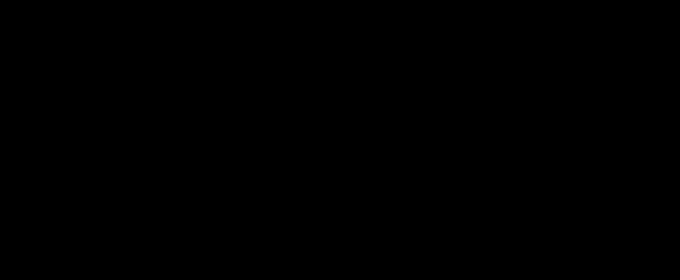

In [12]:
path_to_processed_bias_data
files = sorted(list(os.listdir(path_to_processed_bias_data)))
files = [os.path.join(path_to_processed_bias_data, el) for el in files]
x_files = sorted([f for f in files if f.endswith('_x.nii.gz')])
y_files = sorted([f for f in files if f.endswith('_y.nii.gz')])
save_path = '/scratch_net/biwidl311/lhauptmann/segmentation_3D/data_analysis/data_nib'
for x, y in zip(x_files,y_files):
    print(x)
    plt.figure()
    nilearn.plotting.plot_roi(y,x)
    plt.savefig(os.path.join(save_path, x.replace('_x.nii.gz', '_mask.png')))
    plt.clf()


In [3]:
x = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_x.nii.gz'
y = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/02014629_KO_MCA_y.nii.gz'
st = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_fs_nifti/data/02014629_KO_MCA_stripped.nii.gz'
mask = '/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_fs_nifti/data/02014629_KO_MCA_mask.nii.gz'

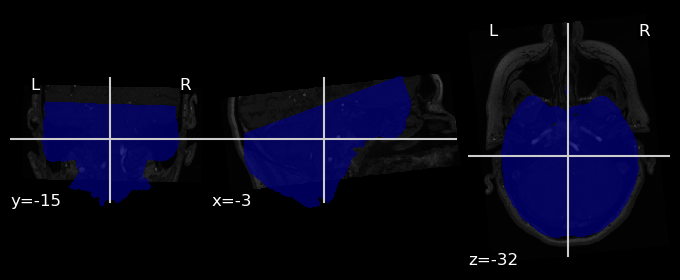

In [6]:

plot_roi(mask,x)

In [3]:
path = "/usr/bmicnas01/data-biwi-01/bmicdatasets-originals/Originals/USZ_BrainArtery/11096773_IB_PComm"
path_pro = "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/"
plot_roi(os.path.join(path, "Segmentation_6.nii"), "/usr/bmicnas01/data-biwi-01/bmicdatasets/Processed/USZ_BrainArtery/USZ_BrainArtery_bias_nifti/data/11096773_IB_PComm_x.nii.gz")